In [599]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

# VEST ME 2018

## VEST's Documentation File

Election results by township from Maine Bureau of Corporations, Elections & Commissions (https://www.maine.gov/sos/cec/elec/results/index.html)
Election results by ward from municipal reports for Auburn, Augusta, Belfast, Biddeford, Ellsworth, Gorham, Harpswell, Lewiston, Portland, Saco, Sanford, South Portland, Westbrook.

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. Voting District shapefiles were available for Androscoggin, Cumberland, Kennebec, Sagadahoc, Waldo, York. County Subdivision shapefiles were used instead for Aroostook, Franklin, Hancock, Knox, Lincoln, Oxford, Penobscot, Piscataquis, Somerset, Washington.

VTDs were merged for Bath, Brunswick, Waterville as statewide votes are not reported by ward. VTDs for Biddeford, Ellsworth, Gorham, Harpswell were sourced from township ward maps.

Absentee votes were reported at the township level for Auburn, Lewiston, Gorham, Harpswell, Portland, Westbrook, Augusta, Belfast, Sanford, South Portland. These were distributed to precincts based on the precinct's share of the township vote for each candidate. Military and overseas ballots (UOCAVA) were reported at the state level. These were distributed to precincts based on the precinct's share of the statewide vote for each candidate.

For Auburn, Biddeford, Lewiston write-in votes reported at the township level were apportioned to precincts in the same shares that the total vote was split among precincts within the township.

The state reported 4930 votes from Gorham for Angus King (I). The precinct-level votes in the Gorham city report add up to 4530 total votes for King. The state reported 4201 votes from Portland for Eric Brakey (R). The precinct-level votes in the Portland city report add up to 4200 total votes for Brakey.

Maine features more than 400 unorganized townships and islands that do not lie within municipal bounds. While some are designated separately, the U.S. Census Bureau combines most of these into larger unorganized territories within each county. Voters in unorganized townships are assigned to nearby incorporated townships. In some cases these votes are reported separately while in others they are combined into the total vote reported from the central voting location. The shapefile has been modified accordingly with boundaries from the Town Boundaries shapefile provided by the Maine Office of GIS. For unorganized territories that are unpopulated or otherwise do not appear to have any registered voters the Census boundaries have been retained unaltered.

G18GOVDMIL - Janet T. Mills (Democratic Party)  
G18GOVRMOO - Shawn Moody (Republican Party)  
G18GOVIHAY - Teresea Hayes (Independent)  
G18GOVOWRI - Write-in Votes  
  
G18USSDRIN - Zak Ringelstein (Democratic Party)  
G18USSRBRA - Eric Brakey (Republican Party)  
G18USSIKIN - Angus King (Independent)  
G18USSOWRI - Write-in Votes  

## Load VEST's Final File

In [600]:
vest_me_18 = gp.read_file("./raw-from-source/VEST/me_2018/me_2018.shp")

In [601]:
vest_me_18.shape

(608, 12)

In [602]:
vest_me_18.head(1)

,STATEFP,COUNTYFP,NAME,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI,geometry
0,23,Androscoggin,Durham,932,1142,113,0,173,924,1125,4,"POLYGON Z ((-70.22462 43.97858 0.00000, -70.21..."


<AxesSubplot:>

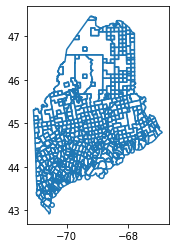

In [603]:
vest_me_18.boundary.plot()

# Election Results

## Load in Election Results

Downloaded SOS Election Results using the same file linked by VEST, and cleaned them in Excel. Results do not require pivoting. 

In [604]:
gov_results = pd.read_csv('./raw-from-source/SOS/governor11-6-18_clean.csv')
sen_results = pd.read_csv('./raw-from-source/SOS/us-senate11-6-18_clean.csv')
gov_results["join_col"]=gov_results['County']+gov_results['Precinct']
sen_results["join_col"]=sen_results['County']+sen_results['Precinct']
gov_results['join_col']=gov_results['join_col'].str.strip()
sen_results['join_col']=sen_results['join_col'].str.strip()

In [605]:
join_attempt_one = pd.merge(gov_results,sen_results,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

both          527
left_only       2
right_only      2
Name: _merge, dtype: int64


In [606]:
pd.set_option('display.max_rows', 10)
join_attempt_one[join_attempt_one['_merge'] != 'both'][['County_x','Precinct_x','County_y','Precinct_y','join_col']]

,County_x,Precinct_x,County_y,Precinct_y,join_col
76,ARO,T15 R6 Twp (Eagle Lake & Wintervlle Plt) ...,NaN,NaN,AROT15 R6 Twp (Eagle Lake & Wintervlle Plt)
452,WAS,Berry/Cathance/MarionTwps (East Machias) ...,NaN,NaN,WASBerry/Cathance/MarionTwps (East Machias)
529,NaN,NaN,ARO,T15 R6 Twp (Eagle Lake & Winterville Plt) ...,AROT15 R6 Twp (Eagle Lake & Winterville Plt)
530,NaN,NaN,WAS,Berry/Cathance/Marion Twps (East Machias) ...,WASBerry/Cathance/Marion Twps (East Machias)


In [607]:
election_names_dict = {
'AROT15 R6 Twp (Eagle Lake & Winterville Plt)':'AROT15 R6 Twp (Eagle Lake & Wintervlle Plt)',
'WASBerry/Cathance/Marion Twps (East Machias)':'WASBerry/Cathance/MarionTwps (East Machias)'    
}

In [608]:
#Use the dictionary to change the names
sen_results["join_col"]=sen_results["join_col"].map(election_names_dict).fillna(sen_results["join_col"])

In [609]:
join_attempt_two = pd.merge(gov_results,sen_results,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          529
left_only       0
right_only      0
Name: _merge, dtype: int64


In [610]:
election_results = join_attempt_two

In [611]:
election_results.head(1)

,County_x,Precinct_x,"Hayes, Teresea M.","Mills, Janet T.","Moody, Shawn H.",Others_x,join_col,County_y,Precinct_y,"Brakey, Eric L.","King, Angus S. Jr.","Ringelstein, Zak",Others_y,_merge
0,AND,Auburn,700,4578,4235,13,ANDAuburn,AND,Auburn,3813,4945,862,0,both


In [612]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Maine"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
me_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))
#Create list of fips codes
fips_file["unique_ID"] =  "23" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()

In [613]:
me_fips_dict

{'ANDROSCOGGIN': '001',
 'AROOSTOOK': '003',
 'CUMBERLAND': '005',
 'FRANKLIN': '007',
 'HANCOCK': '009',
 'KENNEBEC': '011',
 'KNOX': '013',
 'LINCOLN': '015',
 'OXFORD': '017',
 'PENOBSCOT': '019',
 'PISCATAQUIS': '021',
 'SAGADAHOC': '023',
 'SOMERSET': '025',
 'WALDO': '027',
 'WASHINGTON': '029',
 'YORK': '031'}

In [614]:
election_results["County_x"].unique()

array(['AND', 'ARO', 'CUM', 'FRA', 'HAN', 'KEN', 'KNO', 'LIN', 'OXF',
       'PEN', 'PIS', 'SAG', 'SOM', 'WAL', 'WAS', 'YOR'], dtype=object)

In [615]:
County_dict = {
    'AND':'ANDROSCOGGIN', 
    'ARO':'AROOSTOOK', 
    'CUM':'CUMBERLAND', 
    'FRA':'FRANKLIN', 
    'HAN':'HANCOCK', 
    'KEN':'KENNEBEC', 
    'KNO':'KNOX', 
    'LIN':'LINCOLN', 
    'OXF':'OXFORD',
    'PEN':'PENOBSCOT', 
    'PIS':'PISCATAQUIS', 
    'SAG':'SAGADAHOC', 
    'SOM':'SOMERSET', 
    'WAL':'WALDO', 
    'WAS':'WASHINGTON', 
    'YOR':'YORK'
}

In [616]:
#Use the dictionary to change the names
election_results["County_x"]=election_results["County_x"].map(County_dict).fillna(election_results["County_x"])

In [617]:
#Map to the correct FIP
election_results["County_FIPS"]=election_results["County_x"].map(me_fips_dict).fillna(election_results["County_x"])

#Print out the FIPS to make sure they all are in the correct format
election_results["County_x"].unique()

array(['ANDROSCOGGIN', 'AROOSTOOK', 'CUMBERLAND', 'FRANKLIN', 'HANCOCK',
       'KENNEBEC', 'KNOX', 'LINCOLN', 'OXFORD', 'PENOBSCOT',
       'PISCATAQUIS', 'SAGADAHOC', 'SOMERSET', 'WALDO', 'WASHINGTON',
       'YORK'], dtype=object)

In [618]:
election_results = election_results.drop(['join_col', 'County_y','Precinct_y','_merge'], axis=1)

In [619]:
election_results = election_results[["County_x","Precinct_x","County_FIPS","Mills, Janet T.","Moody, Shawn H.","Hayes, Teresea M.","Others_x","Ringelstein, Zak","Brakey, Eric L.","King, Angus S. Jr.","Others_y"]]

In [620]:
election_results.columns = ["County","Precinct","County_FIPS","G18GOVDMIL","G18GOVRMOO","G18GOVIHAY","G18GOVOWRI","G18USSDRIN","G18USSRBRA","G18USSIKIN","G18USSOWRI"]

In [621]:
election_results.head(1)

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,ANDROSCOGGIN,Auburn,001,4578,4235,700,13,862,3813,4945,0


In [622]:
vest_me_18['COUNTYFP']=vest_me_18['COUNTYFP'].str.upper()
vest_me_18["County_FIPS"]=vest_me_18["COUNTYFP"].map(me_fips_dict).fillna(vest_me_18["COUNTYFP"])
vest_me_18

,STATEFP,COUNTYFP,NAME,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI,geometry,County_FIPS
0,23,ANDROSCOGGIN,Durham,932,1142,113,0,173,924,1125,4,"POLYGON Z ((-70.22462 43.97858 0.00000, -70.21...",001
1,23,ANDROSCOGGIN,Auburn Ward 1,911,825,153,7,204,740,979,0,"POLYGON Z ((-70.30199 44.17025 0.00000, -70.30...",001
2,23,ANDROSCOGGIN,Auburn Ward 2,1204,809,145,2,218,751,1197,0,"POLYGON Z ((-70.30412 44.10828 0.00000, -70.30...",001
3,23,ANDROSCOGGIN,Auburn Ward 3,847,949,121,1,139,786,1014,0,"POLYGON Z ((-70.31624 44.09664 0.00000, -70.31...",001
4,23,ANDROSCOGGIN,Auburn Ward 4,730,745,129,1,131,686,802,0,"POLYGON Z ((-70.31467 44.03755 0.00000, -70.31...",001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,23,PENOBSCOT,Old Town,1744,1188,183,1,372,1018,1764,0,"POLYGON Z ((-68.64560 44.94170 0.00000, -68.64...",019
604,23,PENOBSCOT,Penobscot Indian Island,100,32,61,0,54,22,123,0,"POLYGON Z ((-68.64548 44.94174 0.00000, -68.64...",019
605,23,PISCATAQUIS,Atkinson,53,119,17,0,13,102,74,0,"POLYGON Z ((-69.13220 45.19677 0.00000, -69.13...",021
606,23,PISCATAQUIS,Milo/Orneville,356,464,53,0,70,421,402,0,"POLYGON Z ((-68.91354 45.22905 0.00000, -68.91...",021


## Compare vote totals before allocation

In [623]:
races = [x for x in vest_me_18.columns if 'G18' in x]
races

['G18GOVDMIL',
 'G18GOVRMOO',
 'G18GOVIHAY',
 'G18GOVOWRI',
 'G18USSDRIN',
 'G18USSRBRA',
 'G18USSIKIN',
 'G18USSOWRI']

In [624]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_me_18[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

1264729
1260325


## Function to assign absentee votes by town

In [625]:
def assign_absentee(filtered_election):
    to_dole_out = filtered_election[filtered_election['Precinct']=='Absentee']
    to_dole_out_totals = to_dole_out
    filtered_election = filtered_election[filtered_election.Precinct != 'Absentee']
    #Create a df with the county-by-county sums of precinct-level votes, this will be used in the allocation, clean the index
    precinct_specific_totals = pd.DataFrame(filtered_election.groupby(["County"]).sum())
    precinct_specific_totals.reset_index(inplace=True,drop=False)
    filtered_election.reset_index(inplace=True,drop=True)
    
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        filtered_election.loc[:,add_var]=0.0
        filtered_election.loc[:,rem_var]=0.0
        filtered_election.loc[:,floor_var]=0.0
    
    for index, row in filtered_election.iterrows():
        #No countywide votes for 510
        if row["County"] in to_dole_out['County'].unique():
            for race in races:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the county
                county_id = row["County"]
                #Get the denominator for the allocation (the precinct vote totals)
                denom = precinct_specific_totals.loc[precinct_specific_totals["County"]==county_id][race]
                #Get one of the numerators, how many countywide votes to allocate
                numer = to_dole_out_totals.loc[to_dole_out_totals["County"]==county_id][race]

                #Get the vote totals for this race in this precinct
                val = filtered_election.at[index,race]

                #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
                if float(denom) !=0:
                    vote_share = (float(val)/float(denom))*float(numer)
                else:
                    vote_share = 0


                filtered_election.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                filtered_election.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                filtered_election.at[index,floor_var] = np.floor(vote_share)
                
    #After the first pass through, get the sums of the races by county            
    first_allocation = pd.DataFrame(filtered_election.groupby(["County"]).sum())

    #Now we want to iterate county by county to work on rounding
    county_list = list(to_dole_out_totals["County"].unique()) 

    #Iterate over the counties
    for county in county_list:
        for race in races:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["County"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in filtered_election.loc[filtered_election["County"]==county][rem_var].nlargest(to_go).index:
                filtered_election.at[index,add_var] = np.ceil(filtered_election.at[index,add_var])

    #Iterate over every race again
    for race in races:
        add_var = race+"_add"
        #Round every allocation down
        filtered_election.loc[:,add_var]=np.floor(filtered_election.loc[:,add_var])
        #Add every allocation to the total
        filtered_election.loc[:,race]+=filtered_election.loc[:,add_var]


    #Filter back down to the original columns
    filtered_election = filtered_election[list(election_results.columns)]
    return filtered_election

## Assign votes by ward for Auburn, Augusta, Belfast, Biddeford, Ellsworth, Gorham, Harpswell, Lewiston, Portland, Saco, Sanford, South Portland, Westbrook.

VEST:  
-Election results by ward from municipal reports for Auburn, Augusta, Belfast, Biddeford, Ellsworth, Gorham, Harpswell, Lewiston, Portland, Saco, Sanford, South Portland, Westbrook.  
-Absentee votes were reported at the township level for Auburn, Lewiston, Gorham, Harpswell, Portland, Westbrook, Augusta, Belfast, Sanford, South Portland. These were distributed to precincts based on the precinct's share of the township vote for each candidate.  
-For Auburn, Biddeford, Lewiston write-in votes reported at the township level were apportioned to precincts in the same shares that the total vote was split among precincts within the township.  


### Auburn
Source-https://www.auburnmaine.gov/CMSContent/City_Clerk/OFFICIAL%20RESULTS%20-%20BY%20WARD.pdf

In [626]:
Auburn_dict = {'County':['ANDROSCOGGIN', 'ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN'],
        'Precinct':['Auburn Ward 1', 'Auburn Ward 2', 'Auburn Ward 3','Auburn Ward 4','Auburn Ward 5','Absentee'],
        'County_FIPS':['001', '001','001','001','001','001'],
        'G18GOVDMIL':[581,768,540,465,583,1641],
        'G18GOVRMOO':[608,596,699,549,672,1111],
        'G18GOVIHAY':[111,105,88,94,112,190],
        'G18GOVOWRI':[6,0,0,0,0,7],
        'G18USSDRIN':[147,157,100,95,129,234],
        'G18USSRBRA':[548,556,582,508,633,986],
        'G18USSIKIN':[629,769,651,515,625,1756],
        'G18USSOWRI':[0,0,0,0,0,0]
       }
Auburn_df = pd.DataFrame(Auburn_dict)
Auburn_df = assign_absentee(Auburn_df)
Auburn_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,ANDROSCOGGIN,Auburn Ward 1,001,905.0,824.0,152.0,13.0,202.0,739.0,975.0,0.0
1,ANDROSCOGGIN,Auburn Ward 2,001,1197.0,808.0,144.0,0.0,216.0,750.0,1192.0,0.0
2,ANDROSCOGGIN,Auburn Ward 3,001,842.0,948.0,121.0,0.0,137.0,785.0,1010.0,0.0
3,ANDROSCOGGIN,Auburn Ward 4,001,725.0,744.0,129.0,0.0,130.0,685.0,799.0,0.0
4,ANDROSCOGGIN,Auburn Ward 5,001,909.0,911.0,154.0,0.0,177.0,854.0,969.0,0.0


### Augusta
source-Email from town. File available upon request

In [627]:
Augusta_dict = {'County':['KENNEBEC', 'KENNEBEC','KENNEBEC','KENNEBEC','KENNEBEC'],
        'Precinct':['Augusta Ward 1', 'Augusta Ward 2', 'Augusta Ward 3','Augusta Ward 4','Absentee'],
        'County_FIPS':['011', '011','011','011','011'],
        'G18GOVDMIL':[648,676,556,691,1447],
        'G18GOVRMOO':[438,496,627,667,870],
        'G18GOVIHAY':[69,78,83,90,120],
        'G18GOVOWRI':[0,0,0,0,0],
        'G18USSDRIN':[149,124,97,161,180],
        'G18USSRBRA':[335,419,523,540,722],
        'G18USSIKIN':[669,728,637,742,1563],
        'G18USSOWRI':[0,0,0,0,0]
       }
Augusta_df = pd.DataFrame(Augusta_dict)
Augusta_df = assign_absentee(Augusta_df)
Augusta_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,KENNEBEC,Augusta Ward 1,011,1013.0,609.0,95.0,0.0,199.0,468.0,1046.0,0.0
1,KENNEBEC,Augusta Ward 2,011,1056.0,690.0,107.0,0.0,166.0,585.0,1138.0,0.0
2,KENNEBEC,Augusta Ward 3,011,869.0,872.0,114.0,0.0,130.0,731.0,995.0,0.0
3,KENNEBEC,Augusta Ward 4,011,1080.0,927.0,124.0,0.0,216.0,755.0,1160.0,0.0


### Belfast
source-https://www.cityofbelfast.org/DocumentCenter/View/3466/City-Clerks-Return-Election-Results-by-Ward?bidId=

In [628]:
Belfast_dict = {'County':['WALDO', 'WALDO','WALDO'],
        'Precinct':['Belfast Ward 1/2', 'Belfast Ward 3/4', 'Belfast Ward 5'],
        'County_FIPS':['027', '027','027'],
        'G18GOVDMIL':[1007,1010,325],
        'G18GOVRMOO':[305,445,256],
        'G18GOVIHAY':[66,74,31],
        'G18GOVOWRI':[0,0,0],
        'G18USSDRIN':[153,218,58],
        'G18USSRBRA':[254,373,238],
        'G18USSIKIN':[986,942,323],
        'G18USSOWRI':[1,0,0]
       }
Belfast_df = pd.DataFrame(Belfast_dict)
Belfast_df

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,WALDO,Belfast Ward 1/2,027,1007,305,66,0,153,254,986,1
1,WALDO,Belfast Ward 3/4,027,1010,445,74,0,218,373,942,0
2,WALDO,Belfast Ward 5,027,325,256,31,0,58,238,323,0


### Biddeford
source-https://www.biddefordmaine.org/DocumentCenter/View/4110/November-6-2018-State-General--Referendum-Election

In [629]:
Biddeford_dict = {'County':['YORK','YORK','YORK','YORK','YORK','YORK','YORK','YORK'],
        'Precinct':['Biddeford 1','Biddeford 2','Biddeford 3','Biddeford 4','Biddeford 5','Biddeford 6','Biddeford 7','Absentee'],
        'County_FIPS':['031','031','031','031','031','031','031','031'],
        'G18GOVDMIL':[542,416,488,489,402,302,531,1389],
        'G18GOVRMOO':[356,289,328,273,288,213,369,894],
        'G18GOVIHAY':[64,43,59,55,43,31,52,136],
        'G18GOVOWRI':[0,0,1,1,1,1,1,1],
        'G18USSDRIN':[161,128,130,116,116,79,145,242],
        'G18USSRBRA':[263,205,231,201,207,152,283,645],
        'G18USSIKIN':[556,416,527,509,415,319,528,1543],
        'G18USSOWRI':[2,3,0,3,0,1,1,4]
       }
Biddeford_df = pd.DataFrame(Biddeford_dict)
Biddeford_df = assign_absentee(Biddeford_df)
Biddeford_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,YORK,Biddeford 1,031,780.0,506.0,89.0,0.0,206.0,373.0,818.0,3.0
1,YORK,Biddeford 2,031,598.0,411.0,60.0,0.0,163.0,291.0,612.0,4.0
2,YORK,Biddeford 3,031,702.0,467.0,82.0,2.0,166.0,328.0,776.0,0.0
3,YORK,Biddeford 4,031,703.0,388.0,77.0,1.0,148.0,285.0,749.0,4.0
4,YORK,Biddeford 5,031,578.0,410.0,60.0,1.0,148.0,294.0,611.0,0.0
5,YORK,Biddeford 6,031,434.0,303.0,43.0,1.0,101.0,215.0,470.0,2.0
6,YORK,Biddeford 7,031,764.0,525.0,72.0,1.0,185.0,401.0,777.0,1.0


### Ellsworth
source-https://www.ellsworthmaine.gov/wp-content/uploads/2018/11/11-6-2018-Ellsworth-Election-Tally-Sheets.pdf

In [630]:
Ellsworth_dict = {'County':['HANCOCK','HANCOCK','HANCOCK','HANCOCK'],
        'Precinct':['Ellsworth 1',"Ellsworth 2/Fletcher's Landing",'Ellsworth 3','Ellsworth 4'],
        'County_FIPS':['009','009','009','009'],
        'G18GOVDMIL':[709,267,224,547],
        'G18GOVRMOO':[547,294,322,535],
        'G18GOVIHAY':[92,41,30,60],
        'G18GOVOWRI':[0,0,0,0],
        'G18USSDRIN':[144,64,30,111],
        'G18USSRBRA':[476,250,285,464],
        'G18USSIKIN':[726,295,263,578],
        'G18USSOWRI':[0,0,0,0]
       }
Ellsworth_df = pd.DataFrame(Ellsworth_dict)
Ellsworth_df

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,HANCOCK,Ellsworth 1,009,709,547,92,0,144,476,726,0
1,HANCOCK,Ellsworth 2/Fletcher's Landing,009,267,294,41,0,64,250,295,0
2,HANCOCK,Ellsworth 3,009,224,322,30,0,30,285,263,0
3,HANCOCK,Ellsworth 4,009,547,535,60,0,111,464,578,0


### Gorham
source-https://www.gorham-me.org/sites/g/files/vyhlif4456/f/uploads/november_6_2018_state_election_results.pdf

In [631]:
Gorham_dict = {'County':['CUMBERLAND', 'CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['Gorham 1-1', 'Gorham 1-2', 'Gorham 2','Absentee'],
        'County_FIPS':['005', '005','005','005'],
        'G18GOVDMIL':[760,572,1308,1399],
        'G18GOVRMOO':[862,740,1471,1351],
        'G18GOVIHAY':[66,71,155,98],
        'G18GOVOWRI':[0,0,0,0],
        'G18USSDRIN':[188,146,387,260],
        'G18USSRBRA':[561,533,991,884],
        'G18USSIKIN':[937,710,1579,1304],
        'G18USSOWRI':[3,0,0,0]
       }
Gorham_df = pd.DataFrame(Gorham_dict)
Gorham_df = assign_absentee(Gorham_df)
Gorham_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,CUMBERLAND,Gorham 1-1,005,1163.0,1241.0,88.0,0.0,256.0,799.0,1316.0,3.0
1,CUMBERLAND,Gorham 1-2,005,875.0,1065.0,95.0,0.0,199.0,759.0,997.0,0.0
2,CUMBERLAND,Gorham 2,005,2001.0,2118.0,207.0,0.0,526.0,1411.0,2217.0,0.0


### Harpswell
source-File available upon request

In [632]:
Harpswell_dict = {'County':['CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['Harpswell - Mainland','Harpswell - Great Island',"Harpswell - Orr's/Bailey",'Absentee'],
        'County_FIPS':['005','005','005','005'],
        'G18GOVDMIL':[551,438,250,549],
        'G18GOVRMOO':[383,381,186,260],
        'G18GOVIHAY':[60,33,25,31],
        'G18GOVOWRI':[0,0,0,0],
        'G18USSDRIN':[58,62,20,48],
        'G18USSRBRA':[294,320,142,219],
        'G18USSIKIN':[667,484,310,587],
        'G18USSOWRI':[0,0,0,0]
       }
Harpswell_df = pd.DataFrame(Harpswell_dict)
Harpswell_df = assign_absentee(Harpswell_df)
Harpswell_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,CUMBERLAND,Harpswell - Mainland,005,795.0,488.0,76.0,0.0,78.0,379.0,935.0,0.0
1,CUMBERLAND,Harpswell - Great Island,005,632.0,485.0,42.0,0.0,83.0,413.0,678.0,0.0
2,CUMBERLAND,Harpswell - Orr's/Bailey,005,361.0,237.0,31.0,0.0,27.0,183.0,435.0,0.0


### Lewiston
source-http://www.lewistonmaine.gov/DocumentCenter/View/9626/November-6-2018-General-and-Referendum-Election-Results?bidId=

In [633]:
Lewiston_dict = {'County':['ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN'],
        'Precinct':['Lewiston Ward 1','Lewiston Ward 2','Lewiston Ward 3','Lewiston Ward 4','Lewiston Ward 5','Lewiston Ward 6','Lewiston Ward 7','Absentee'],
        'County_FIPS':['001','001','001','001','001','001','001','001'],
        'G18GOVDMIL':[851,679,735,537,466,581,523,2684],
        'G18GOVRMOO':[383,885,201,601,203,884,591,1749],
        'G18GOVIHAY':[85,121,76,113,61,104,90,312],
        'G18GOVOWRI':[0,0,0,0,0,0,0,0],
        'G18USSDRIN':[321,141,314,112,206,129,134,585],
        'G18USSRBRA':[332,714,181,503,174,754,500,1481],
        'G18USSIKIN':[678,828,545,653,343,706,578,2662],
        'G18USSOWRI':[0,0,0,0,0,0,0,0]
       }
Lewiston_df = pd.DataFrame(Lewiston_dict)
Lewiston_df = assign_absentee(Lewiston_df)
Lewiston_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,ANDROSCOGGIN,Lewiston Ward 1,001,1373.0,562.0,126.0,0.0,459.0,488.0,1095.0,0.0
1,ANDROSCOGGIN,Lewiston Ward 2,001,1096.0,1298.0,179.0,0.0,202.0,1049.0,1337.0,0.0
2,ANDROSCOGGIN,Lewiston Ward 3,001,1186.0,295.0,113.0,0.0,449.0,266.0,880.0,0.0
3,ANDROSCOGGIN,Lewiston Ward 4,001,867.0,881.0,167.0,0.0,160.0,739.0,1054.0,0.0
4,ANDROSCOGGIN,Lewiston Ward 5,001,752.0,298.0,90.0,0.0,295.0,255.0,554.0,0.0
5,ANDROSCOGGIN,Lewiston Ward 6,001,938.0,1296.0,154.0,0.0,185.0,1108.0,1140.0,0.0
6,ANDROSCOGGIN,Lewiston Ward 7,001,844.0,867.0,133.0,0.0,192.0,734.0,933.0,0.0


### Portland
source-Files available upon request

In [634]:
print(vest_me_18[vest_me_18['NAME'].str.contains('Portland Precinct')])
election_results[election_results['Precinct']=='Portland']

   STATEFP    COUNTYFP                   NAME  G18GOVDMIL  G18GOVRMOO  \
35      23  CUMBERLAND  Portland Precinct 1-2        2222         352   
36      23  CUMBERLAND  Portland Precinct 3-2        2558         666   
41      23  CUMBERLAND  Portland Precinct 3-1        2865         587   
45      23  CUMBERLAND  Portland Precinct 2-1        3456         306   
50      23  CUMBERLAND  Portland Precinct 1-1        2737         332   
..     ...         ...                    ...         ...         ...   
52      23  CUMBERLAND  Portland Precinct 1-3         606         109   
53      23  CUMBERLAND  Portland Precinct 4-1        3100         639   
54      23  CUMBERLAND  Portland Precinct 4-2        1778         648   
55      23  CUMBERLAND  Portland Precinct 5-1        1793         560   
56      23  CUMBERLAND  Portland Precinct 5-2        2638        1200   

    G18GOVIHAY  G18GOVOWRI  G18USSDRIN  G18USSRBRA  G18USSIKIN  G18USSOWRI  \
35         143           0         898       

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
107,CUMBERLAND,Portland,005,26237,5675,1364,0,7479,4201,21802,0


In [635]:
Portland_dict = {'County':['CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['Portland Precinct 1-1','Portland Precinct 1-2','Portland Precinct 1-3','Portland Precinct 2-1','Portland Precinct 2-2','Portland Precinct 3-1','Portland Precinct 3-2','Portland Precinct 4-1','Portland Precinct 4-2','Portland Precinct 5-1','Portland Precinct 5-2','Absentee'],
        'County_FIPS':['005','005','005','005','005','005','005','005','005','005','005','005'],
        'G18GOVDMIL':[1929,1566,427,2436,1866,2019,1803,2185,1253,1264,1860,7629],
        'G18GOVRMOO':[249,264,82,229,211,439,498,478,485,419,898,1423],
        'G18GOVIHAY':[64,105,13,109,97,118,105,121,84,63,128,357],
        'G18GOVOWRI':[0,0,0,0,0,0,0,0,0,0,0,0],
        'G18USSDRIN':[593,685,113,829,815,581,438,623,323,374,396,1709],
        'G18USSRBRA':[183,192,51,163,157,328,394,350,341,302,678,1061],
        'G18USSIKIN':[1481,1066,358,1809,1223,1696,1599,1792,1155,1050,1798,6775],
        'G18USSOWRI':[0,0,0,0,0,0,0,0,0,0,0,0]
       }
Portland_df = pd.DataFrame(Portland_dict)
Portland_df = assign_absentee(Portland_df)
Portland_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,CUMBERLAND,Portland Precinct 1-1,005,2720.0,332.0,87.0,0.0,769.0,245.0,2149.0,0.0
1,CUMBERLAND,Portland Precinct 1-2,005,2208.0,352.0,142.0,0.0,888.0,257.0,1547.0,0.0
2,CUMBERLAND,Portland Precinct 1-3,005,602.0,109.0,18.0,0.0,146.0,68.0,519.0,0.0
3,CUMBERLAND,Portland Precinct 2-1,005,3435.0,306.0,148.0,0.0,1075.0,218.0,2624.0,0.0
4,CUMBERLAND,Portland Precinct 2-2,005,2631.0,282.0,131.0,0.0,1056.0,210.0,1774.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6,CUMBERLAND,Portland Precinct 3-2,005,2542.0,665.0,142.0,0.0,568.0,527.0,2320.0,0.0
7,CUMBERLAND,Portland Precinct 4-1,005,3081.0,638.0,164.0,0.0,807.0,469.0,2600.0,0.0
8,CUMBERLAND,Portland Precinct 4-2,005,1767.0,647.0,114.0,0.0,419.0,456.0,1676.0,0.0
9,CUMBERLAND,Portland Precinct 5-1,005,1782.0,559.0,85.0,0.0,485.0,404.0,1523.0,0.0


In [636]:
pd.set_option('display.max_rows', 20)
print(Portland_df.sum(axis = 0))
pd.set_option('display.max_rows', 10)

County         CUMBERLANDCUMBERLANDCUMBERLANDCUMBERLANDCUMBER...
Precinct       Portland Precinct 1-1Portland Precinct 1-2Port...
County_FIPS                    005005005005005005005005005005005
G18GOVDMIL                                               26237.0
G18GOVRMOO                                                5675.0
G18GOVIHAY                                                1364.0
G18GOVOWRI                                                   0.0
G18USSDRIN                                                7479.0
G18USSRBRA                                                4200.0
G18USSIKIN                                               21802.0
G18USSOWRI                                                   0.0
dtype: object


### Saco
source-https://www.sacomaine.org/City%20Clerk/Elections/Saco%20-%20Official%20Election%20Results.pdf

In [637]:
Saco_dict = {'County':['YORK','YORK','YORK','YORK','YORK','YORK','YORK'],
        'Precinct':['Saco Ward 1','Saco Ward 2','Saco Ward 3','Saco Ward 4','Saco Ward 5','Saco Ward 6','Saco Ward 7'],
        'County_FIPS':['031','031','031','031','031','031','031'],
        'G18GOVDMIL':[699,641,627,975,729,755,701],
        'G18GOVRMOO':[559,599,487,629,485,417,316],
        'G18GOVIHAY':[79,68,64,73,72,65,71],
        'G18GOVOWRI':[0,0,1,0,0,0,0],
        'G18USSDRIN':[117,118,143,110,170,142,165],
        'G18USSRBRA':[421,455,374,480,357,313,239],
        'G18USSIKIN':[806,736,662,1074,737,781,679],
        'G18USSOWRI':[0,0,0,0,0,0,0]
       }
Saco_df = pd.DataFrame(Saco_dict)
Saco_df

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,YORK,Saco Ward 1,031,699,559,79,0,117,421,806,0
1,YORK,Saco Ward 2,031,641,599,68,0,118,455,736,0
2,YORK,Saco Ward 3,031,627,487,64,1,143,374,662,0
3,YORK,Saco Ward 4,031,975,629,73,0,110,480,1074,0
4,YORK,Saco Ward 5,031,729,485,72,0,170,357,737,0
5,YORK,Saco Ward 6,031,755,417,65,0,142,313,781,0
6,YORK,Saco Ward 7,031,701,316,71,0,165,239,679,0


### Sanford
source-https://www.sanfordmaine.org/vertical/sites/%7B9A3D3C8D-76EE-4CC5-B86E-C19FDBF5E473%7D/uploads/OFFICIAL_Tally_Nov_6_2018.pdf

In [638]:
Sanford_dict = {'County':['YORK','YORK','YORK','YORK'],
        'Precinct':['Sanford Ward 1','Sanford Ward 2','Sanford Ward 3','Absentee'],
        'County_FIPS':['031','031','031','031'],
        'G18GOVDMIL':[868,853,873,780],
        'G18GOVRMOO':[893,856,1055,660],
        'G18GOVIHAY':[129,140,126,98],
        'G18GOVOWRI':[0,0,0,0],
        'G18USSDRIN':[208,243,237,173],
        'G18USSRBRA':[660,674,811,510],
        'G18USSIKIN':[955,940,1017,880],
        'G18USSOWRI':[0,0,0,0]
       }
Sanford_df = pd.DataFrame(Sanford_dict)
Sanford_df = assign_absentee(Sanford_df)
Sanford_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,YORK,Sanford Ward 1,031,1129.0,1103.0,161.0,0.0,260.0,817.0,1244.0,0.0
1,YORK,Sanford Ward 2,031,1109.0,1058.0,175.0,0.0,304.0,834.0,1224.0,0.0
2,YORK,Sanford Ward 3,031,1136.0,1303.0,157.0,0.0,297.0,1004.0,1324.0,0.0


### South Portland
source-https://www.southportland.org/files/9215/4172/0820/OFFICIAL_RESULTS_-_STATE_-_11-06-18.pdf

In [639]:
SouthPortland_dict = {'County':['CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['South Portland District 1','South Portland District 2','South Portland District 3/4','South Portland District 5','Absentee'],
        'County_FIPS':['005','005','005','005','005'],
        'G18GOVDMIL':[1349,1379,2186,811,3347],
        'G18GOVRMOO':[406,433,1070,410,989],
        'G18GOVIHAY':[85,91,211,77,183],
        'G18GOVOWRI':[3,4,7,5,2],
        'G18USSDRIN':[311,328,632,281,603],
        'G18USSRBRA':[292,310,822,322,749],
        'G18USSIKIN':[1234,1270,1989,707,3185],
        'G18USSOWRI':[1,2,4,5,2]
       }
SouthPortland_df = pd.DataFrame(SouthPortland_dict)
SouthPortland_df = assign_absentee(SouthPortland_df)
SouthPortland_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,CUMBERLAND,South Portland District 1,005,2138.0,579.0,119.0,3.0,432.0,417.0,1990.0,1.0
1,CUMBERLAND,South Portland District 2,005,2185.0,618.0,127.0,4.0,455.0,443.0,2048.0,2.0
2,CUMBERLAND,South Portland District 3/4,005,3464.0,1526.0,294.0,8.0,878.0,1175.0,3207.0,5.0
3,CUMBERLAND,South Portland District 5,005,1285.0,585.0,107.0,6.0,390.0,460.0,1140.0,6.0


### Westbrook
source-https://www.westbrookmaine.com/DocumentCenter/View/1533/Westbrook-Official-Election-Results---20181106?bidId=

In [640]:
print(vest_me_18[vest_me_18['NAME'].str.contains('Westbrook')])
election_results[election_results['Precinct']=='Westbrook']

   STATEFP    COUNTYFP              NAME  G18GOVDMIL  G18GOVRMOO  G18GOVIHAY  \
60      23  CUMBERLAND  Westbrook Ward 1         896         616          88   
61      23  CUMBERLAND  Westbrook Ward 4         914         485          78   
62      23  CUMBERLAND  Westbrook Ward 5        1138         839          98   
63      23  CUMBERLAND  Westbrook Ward 2        1164         496          97   
64      23  CUMBERLAND  Westbrook Ward 3         860         584         109   

    G18GOVOWRI  G18USSDRIN  G18USSRBRA  G18USSIKIN  G18USSOWRI  \
60           0         234         463         920           0   
61           0         270         349         867           0   
62           0         245         580        1234           0   
63           0         340         355        1066           0   
64           0         206         453         901           0   

                                             geometry County_FIPS  
60  POLYGON Z ((-70.36096 43.68857 0.00000, -70.36... 

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
114,CUMBERLAND,Westbrook,005,4941,3015,470,0,1280,2196,4966,0


In [641]:
Westbrook_dict = {'County':['CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['Westbrook Ward 1','Westbrook Ward 2','Westbrook Ward 3','Westbrook Ward 4','Westbrook Ward 5','Absentee'],
        'County_FIPS':['005','005','005','005','005','005'],
        'G18GOVDMIL':[586,762,563,598,745,1687],
        'G18GOVRMOO':[431,347,408,339,587,903],
        'G18GOVIHAY':[61,67,76,54,68,144],
        'G18GOVOWRI':[0,0,0,0,0,0],
        'G18USSDRIN':[164,239,145,190,172,370],
        'G18USSRBRA':[324,248,317,245,406,656],
        'G18USSIKIN':[602,697,589,567,807,1704],
        'G18USSOWRI':[0,0,0,0,0,0]
       }
Westbrook_df = pd.DataFrame(Westbrook_dict)
Westbrook_df = assign_absentee(Westbrook_df)
Westbrook_df

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,CUMBERLAND,Westbrook Ward 1,005,890.0,615.0,88.0,0.0,231.0,462.0,916.0,0.0
1,CUMBERLAND,Westbrook Ward 2,005,1157.0,495.0,97.0,0.0,336.0,354.0,1061.0,0.0
2,CUMBERLAND,Westbrook Ward 3,005,855.0,583.0,109.0,0.0,204.0,452.0,897.0,0.0
3,CUMBERLAND,Westbrook Ward 4,005,908.0,484.0,78.0,0.0,267.0,349.0,863.0,0.0
4,CUMBERLAND,Westbrook Ward 5,005,1131.0,838.0,98.0,0.0,242.0,579.0,1229.0,0.0


In [642]:
pd.set_option('display.max_rows', 20)
print(Westbrook_df.sum(axis = 0))
pd.set_option('display.max_rows', 10)

County         CUMBERLANDCUMBERLANDCUMBERLANDCUMBERLANDCUMBER...
Precinct       Westbrook Ward 1Westbrook Ward 2Westbrook Ward...
County_FIPS                                      005005005005005
G18GOVDMIL                                                4941.0
G18GOVRMOO                                                3015.0
G18GOVIHAY                                                 470.0
G18GOVOWRI                                                   0.0
G18USSDRIN                                                1280.0
G18USSRBRA                                                2196.0
G18USSIKIN                                                4966.0
G18USSOWRI                                                   0.0
dtype: object


In [643]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_me_18[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

1264729
1260325


In [644]:
Precincts=['Auburn', 'Augusta', 'Belfast', 'Biddeford', 'Ellsworth', 'Gorham', 'Harpswell', 'Lewiston', 'Portland', 'Saco', 'Sanford', 'South Portland', 'Westbrook']

In [645]:
pd.set_option('display.max_rows', 20)
print(election_results[election_results['Precinct'].isin(Precincts)])
pd.set_option('display.max_rows', 10)

           County        Precinct County_FIPS  G18GOVDMIL  G18GOVRMOO  \
0    ANDROSCOGGIN          Auburn         001        4578        4235   
4    ANDROSCOGGIN        Lewiston         001        7056        5497   
99     CUMBERLAND          Gorham         005        4039        4424   
101    CUMBERLAND       Harpswell         005        1788        1210   
107    CUMBERLAND        Portland         005       26237        5675   
112    CUMBERLAND  South Portland         005        9072        3308   
114    CUMBERLAND       Westbrook         005        4941        3015   
154       HANCOCK       Ellsworth         009        1747        1698   
181      KENNEBEC         Augusta         011        4018        3098   
424         WALDO         Belfast         027        2342        1006   
504          YORK       Biddeford         031        4559        3010   
522          YORK            Saco         031        5127        3492   
523          YORK         Sanford         031      

In [646]:

#'Portland'
election_results = election_results[~election_results['Precinct'].isin(Precincts)]

In [647]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_me_18[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

1264729
1001728


In [648]:
election_results = pd.concat([election_results,Auburn_df,Augusta_df,Belfast_df,Biddeford_df,Ellsworth_df,Gorham_df,Harpswell_df,Lewiston_df,Portland_df,Saco_df,Sanford_df,SouthPortland_df,Westbrook_df], ignore_index = True)


In [649]:
election_results[election_results['Precinct'].str.contains('Westbrook')]

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
577,CUMBERLAND,Westbrook Ward 1,005,890.0,615.0,88.0,0.0,231.0,462.0,916.0,0.0
578,CUMBERLAND,Westbrook Ward 2,005,1157.0,495.0,97.0,0.0,336.0,354.0,1061.0,0.0
579,CUMBERLAND,Westbrook Ward 3,005,855.0,583.0,109.0,0.0,204.0,452.0,897.0,0.0
580,CUMBERLAND,Westbrook Ward 4,005,908.0,484.0,78.0,0.0,267.0,349.0,863.0,0.0
581,CUMBERLAND,Westbrook Ward 5,005,1131.0,838.0,98.0,0.0,242.0,579.0,1229.0,0.0


In [650]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_me_18[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

1264729
1259962.0


In [651]:
for race in races:
    diff_val = sum(vest_me_18[race])-sum(election_results[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL : " + str(sum(vest_me_18[race])))

G18GOVDMIL: 1978.0
G18GOVRMOO: 277.0
G18GOVIHAY: 74.0
G18GOVOWRI: 13.0
G18USSDRIN: 698.0
G18USSRBRA: 249.0
G18USSIKIN: 1475.0
G18USSOWRI: 3.0


### Allocate UOCAVA votes
UOCAVA: https://www.maine.gov/sos/cec/elec/upcoming/UOCAVA-ROVC.pdf

In [652]:
data = [['ABS','Absentee','000',1978,277,74,0,698,249,1475,0]]
 
# Create dataframe of absentee votes
to_dole_out_totals = pd.DataFrame(data, columns = ["County","Precinct","County_FIPS","G18GOVDMIL","G18GOVRMOO","G18GOVIHAY","G18GOVOWRI","G18USSDRIN","G18USSRBRA","G18USSIKIN","G18USSOWRI"])


In [653]:
df_with_absentee_reallocated = election_results

In [654]:
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
precinct_vote_total_across_districts = totals.T

In [655]:
precinct_vote_total_across_districts

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,ANDROSCOGGINANDROSCOGGINANDROSCOGGINANDROSCOGG...,DurhamGreeneLeedsLisbonLivermoreLivermore Fall...,0010010010010010010010010010010010010030030030...,318984.0,272034.0,37194.0,139.0,65570.0,223252.0,342700.0,89.0


In [656]:
to_dole_out_totals

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI
0,ABS,Absentee,000,1978,277,74,0,698,249,1475,0


In [657]:
races=["G18GOVDMIL","G18GOVRMOO","G18GOVIHAY","G18GOVOWRI","G18USSDRIN","G18USSRBRA","G18USSIKIN","G18USSOWRI"]


#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    df_with_absentee_reallocated.loc[:,add_var]=0.0
    df_with_absentee_reallocated.loc[:,rem_var]=0.0
    df_with_absentee_reallocated.loc[:,floor_var]=0.0

for index, row in df_with_absentee_reallocated.iterrows():
    for race in races:
            add_var = race+"_fed_add"
            rem_var = race+"_fed_rem"
            floor_var = race+"_fed_floor"
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_vote_total_across_districts.iloc[0][race]
            #Get one of the numerators, how many countywide votes to allocate
            numer = to_dole_out_totals.iloc[0][race]
            #Get the vote totals for this race in this precinct
            val = df_with_absentee_reallocated.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
            vote_share = (float(val)/float(denom))*float(numer)
            df_with_absentee_reallocated.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            df_with_absentee_reallocated.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            df_with_absentee_reallocated.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by county 
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
first_allocation = totals.T

for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
    to_go = int(np.round((int(to_dole_out_totals.iloc[0][race])-first_allocation.iloc[0][floor_var])))
    #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
    for index in df_with_absentee_reallocated[rem_var].nlargest(to_go).index:
        df_with_absentee_reallocated.at[index,add_var] = np.ceil(df_with_absentee_reallocated.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_fed_add"
    #Round every allocation down
    df_with_absentee_reallocated.loc[:,add_var]=np.floor(df_with_absentee_reallocated.loc[:,add_var])
    df_with_absentee_reallocated.loc[:,race]+=df_with_absentee_reallocated.loc[:,add_var]

In [658]:
df_with_absentee_reallocated['County_FIPS'].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031'], dtype=object)

In [659]:
vest_me_18['COUNTYFP'].unique()

array(['ANDROSCOGGIN', 'CUMBERLAND', 'KENNEBEC', 'SAGADAHOC', 'WALDO',
       'YORK', 'FRANKLIN', 'WASHINGTON', 'PISCATAQUIS', 'LINCOLN',
       'PENOBSCOT', 'AROOSTOOK', 'OXFORD', 'SOMERSET', 'HANCOCK', 'KNOX'],
      dtype=object)

## Compare Election Result Totals

In [660]:
races = [x for x in vest_me_18.columns if 'G18' in x]
races

['G18GOVDMIL',
 'G18GOVRMOO',
 'G18GOVIHAY',
 'G18GOVOWRI',
 'G18USSDRIN',
 'G18USSRBRA',
 'G18USSIKIN',
 'G18USSOWRI']

### Compare Vote Totals

In [661]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_me_18[i])
    sum_var_2 += np.sum(df_with_absentee_reallocated[i])
print(sum_var_1)
print(sum_var_2)

1264729
1264713.0


### Compare Race Totals

In [662]:
for race in races:
    diff_val = sum(vest_me_18[race])-sum(df_with_absentee_reallocated[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL : " + str(sum(vest_me_18[race])))

G18GOVDMIL: EQUAL : 320962
G18GOVRMOO: EQUAL : 272311
G18GOVIHAY: EQUAL : 37268
G18GOVOWRI: 13.0
G18USSDRIN: EQUAL : 66268
G18USSRBRA: EQUAL : 223501
G18USSIKIN: EQUAL : 344175
G18USSOWRI: 3.0


### Compare County Totals

In [663]:
diff_counties=[]
for i in races:
    diff = df_with_absentee_reallocated.groupby(["County_FIPS"]).sum()[i]-vest_me_18.groupby(["County_FIPS"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i+'\n'+ diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(i + ' county totals: EQUAL')


G18GOVDMIL
003   -13.0
009    -7.0
019    35.0
021   -19.0
029     4.0 NOT EQUAL
G18GOVRMOO
003   -12.0
009   -11.0
019    49.0
021   -35.0
029     9.0 NOT EQUAL
G18GOVIHAY
003   -1.0
009   -2.0
019    2.0
021   -1.0
029    2.0 NOT EQUAL
G18GOVOWRI
001   -13.0 NOT EQUAL
G18USSDRIN
003   -2.0
009   -2.0
019    3.0
021   -1.0
029    2.0 NOT EQUAL
G18USSRBRA
003    -9.0
009   -12.0
019    42.0
021   -31.0
029    10.0 NOT EQUAL
G18USSIKIN
003   -16.0
009    -6.0
019    45.0
021   -26.0
029     3.0 NOT EQUAL
G18USSOWRI
001   -3.0 NOT EQUAL


In [664]:
#Add join columns to both
vest_me_18["join_col"]=vest_me_18['County_FIPS']+vest_me_18['NAME']
df_with_absentee_reallocated["join_col"]=df_with_absentee_reallocated["County_FIPS"]+df_with_absentee_reallocated["Precinct"]

In [665]:
#Check to make sure that the join_col in both files is unique

print(len(df_with_absentee_reallocated["join_col"]))
print(df_with_absentee_reallocated["join_col"].value_counts().sum())

print(len(vest_me_18["join_col"]))
print(vest_me_18["join_col"].value_counts().sum())

582
582
608
608


In [666]:
#Uppercase both join columns
df_with_absentee_reallocated['join_col'] = df_with_absentee_reallocated['join_col'].str.upper()
vest_me_18['join_col'] = vest_me_18['join_col'].str.upper()
#Strip white space
df_with_absentee_reallocated['join_col']=df_with_absentee_reallocated['join_col'].str.strip()
vest_me_18['join_col']=vest_me_18['join_col'].str.strip()

In [667]:
vest_me_18[vest_me_18['County_FIPS'] == '019']

,STATEFP,COUNTYFP,NAME,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,G18USSOWRI,geometry,County_FIPS,join_col
188,23,PENOBSCOT,Maxfield,15,28,1,0,3,29,14,0,"POLYGON Z ((-68.80091 45.32915 0.00000, -68.79...",019,019MAXFIELD
189,23,PENOBSCOT,Patten,136,221,24,0,18,176,172,0,"POLYGON Z ((-68.55924 45.99820 0.00000, -68.55...",019,019PATTEN
196,23,PENOBSCOT,Brewer,1893,1895,218,0,332,1649,2053,0,"POLYGON Z ((-68.78720 44.76780 0.00000, -68.78...",019,019BREWER
225,23,PENOBSCOT,Burlington,48,93,7,0,9,80,56,0,"POLYGON Z ((-68.46529 45.29666 0.00000, -68.46...",019,019BURLINGTON
226,23,PENOBSCOT,Charleston,130,424,18,0,31,398,151,0,"POLYGON Z ((-69.10944 45.10719 0.00000, -69.10...",019,019CHARLESTON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,23,PENOBSCOT,East Millinocket/Dolby,365,368,39,0,49,319,406,0,"POLYGON Z ((-68.61506 45.67035 0.00000, -68.61...",019,019EAST MILLINOCKET/DOLBY
589,23,PENOBSCOT,North Penobscot,0,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-68.82590 45.76105 0.00000, ...",019,019NORTH PENOBSCOT
599,23,PENOBSCOT,Carroll,9,55,5,0,2,52,15,0,"POLYGON Z ((-68.11447 45.44604 0.00000, -68.11...",019,019CARROLL
603,23,PENOBSCOT,Old Town,1744,1188,183,1,372,1018,1764,0,"POLYGON Z ((-68.64560 44.94170 0.00000, -68.64...",019,019OLD TOWN


In [668]:
df_with_absentee_reallocated[df_with_absentee_reallocated['G18GOVDMIL']==0]

,County,Precinct,County_FIPS,G18GOVDMIL,G18GOVRMOO,G18GOVIHAY,G18GOVOWRI,G18USSDRIN,G18USSRBRA,G18USSIKIN,...,G18USSRBRA_fed_add,G18USSRBRA_fed_rem,G18USSRBRA_fed_floor,G18USSIKIN_fed_add,G18USSIKIN_fed_rem,G18USSIKIN_fed_floor,G18USSOWRI_fed_add,G18USSOWRI_fed_rem,G18USSOWRI_fed_floor,join_col
33,AROOSTOOK,Glenwood Plt,003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,003GLENWOOD PLT
74,AROOSTOOK,T15 R6 Twp (Eagle Lake & Wintervlle Plt) ...,003,0.0,6.0,0.0,0.0,0.0,5.0,1.0,...,0.0,0.005577,0.0,0.0,0.004304,0.0,0.0,0.0,0.0,003T15 R6 TWP (EAGLE LAKE & WINTERVLLE PLT)
330,PENOBSCOT,Orneville Twp (Lagrange),019,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.001115,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,019ORNEVILLE TWP (LAGRANGE)
383,SOMERSET,Concord Twp (Solon),025,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.001115,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,025CONCORD TWP (SOLON)
481,WASHINGTON,T26 ED BPP Twp (Wesley) ...,029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,029T26 ED BPP TWP (WESLEY)


31-5= 26 zero vote precincts different

## Attempt Join

In [669]:
join_attempt_one = pd.merge(df_with_absentee_reallocated,vest_me_18,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

both          469
right_only    139
left_only     113
Name: _merge, dtype: int64


In [670]:
join_attempt_one.columns

Index(['County', 'Precinct', 'County_FIPS_x', 'G18GOVDMIL_x', 'G18GOVRMOO_x',
       'G18GOVIHAY_x', 'G18GOVOWRI_x', 'G18USSDRIN_x', 'G18USSRBRA_x',
       'G18USSIKIN_x', 'G18USSOWRI_x', 'G18GOVDMIL_fed_add',
       'G18GOVDMIL_fed_rem', 'G18GOVDMIL_fed_floor', 'G18GOVRMOO_fed_add',
       'G18GOVRMOO_fed_rem', 'G18GOVRMOO_fed_floor', 'G18GOVIHAY_fed_add',
       'G18GOVIHAY_fed_rem', 'G18GOVIHAY_fed_floor', 'G18GOVOWRI_fed_add',
       'G18GOVOWRI_fed_rem', 'G18GOVOWRI_fed_floor', 'G18USSDRIN_fed_add',
       'G18USSDRIN_fed_rem', 'G18USSDRIN_fed_floor', 'G18USSRBRA_fed_add',
       'G18USSRBRA_fed_rem', 'G18USSRBRA_fed_floor', 'G18USSIKIN_fed_add',
       'G18USSIKIN_fed_rem', 'G18USSIKIN_fed_floor', 'G18USSOWRI_fed_add',
       'G18USSOWRI_fed_rem', 'G18USSOWRI_fed_floor', 'join_col', 'STATEFP',
       'COUNTYFP', 'NAME', 'G18GOVDMIL_y', 'G18GOVRMOO_y', 'G18GOVIHAY_y',
       'G18GOVOWRI_y', 'G18USSDRIN_y', 'G18USSRBRA_y', 'G18USSIKIN_y',
       'G18USSOWRI_y', 'geometry', 'County_

In [671]:
pd.set_option('display.max_rows', 10)
join_attempt_one[join_attempt_one['_merge'] != 'both'][['County_FIPS_x','Precinct','County_FIPS_y','NAME','join_col']]

,County_FIPS_x,Precinct,County_FIPS_y,NAME,join_col
17,003,Caribou (and Connor Twp),NaN,NaN,003CARIBOU (AND CONNOR TWP)
18,003,Cary Plt,NaN,NaN,003CARY PLT
22,003,Cross Lake Twp (New Canada),NaN,NaN,003CROSS LAKE TWP (NEW CANADA)
24,003,Cyr Plt,NaN,NaN,003CYR PLT
26,003,E Twp (Blaine) ...,NaN,NaN,003E TWP (BLAINE)
...,...,...,...,...,...
716,NaN,NaN,007,Adamstown/Lower Cupsuptic,007ADAMSTOWN/LOWER CUPSUPTIC
717,NaN,NaN,019,Old Town,019OLD TOWN
718,NaN,NaN,019,Penobscot Indian Island,019PENOBSCOT INDIAN ISLAND
719,NaN,NaN,021,Milo/Orneville,021MILO/ORNEVILLE


In [672]:
source_vest_names_dict = {'003CARIBOU (AND CONNOR TWP)': '003CARIBOU/CONNOR',
 '003CARY PLT': '003CARY',
 '003CROSS LAKE TWP (NEW CANADA)': '003CROSS LAKE',
 '003CYR PLT': '003CYR',
 '003E TWP (BLAINE)': '003E TWP',
 '003FORT KENT': '003FORT KENT/BIG TWENTY/T15 R15',
 '003GARFIELD PLT': '003GARFIELD',
 '003GLENWOOD PLT': '003GLENWOOD',
 '003MACWAHOC PLT': '003MACWAHOC',
 '003MORO PLT': '003MORO/T7 R5',
 '003NASHVILLE PLT': '003NASHVILLE',
 '003OXBOW NORTH TWP (MASARDIS)': '003OXBOW NORTH',
 '003REED PLT': '003REED/UPPER MOLUNKUS',
 '003SAINT AGATHA/SINCLAIR': '003ST. AGATHA/SINCLAIR',
 '003SAINT FRANCIS': '003ST. FRANCIS',
 '003SAINT JOHN PLT': '003ST. JOHN',
 '003SHERMAN (AND BENEDICTA & SILVER RIDGE TWPS)': '003SHERMAN/BENEDICTA/SILVER RIDGE',
 '003T11 R4 WELS TWP (CASTLE HILL)': '003T11 R4 WELS',
 '003T12 R13 &T9 R8 WELS (ASHLAND)': '003T12 R13 WELS/T9 R8 WELS',
 '003T15 R6 TWP (EAGLE LAKE & WINTERVLLE PLT)': '003T15 R6 WELS',
 '003T17 R3 (VAN BUREN)': '003T17 R3',
 '003T4 R3 TWP (ISLAND FALLS)': '003T4 R3',
 '003TD R2 TWP': '003TD R2 WELS',
 '003WESTON': '003WESTON/BANCROFT',
 '003WINTERVILLE PLT': '003WINTERVILLE',
 '005BRUNSWICK': '005BRUNSWICK 1-7',
 '007ADAMSTOWN/LOWER CUPSUPTIC TWPS (RANGELEY)': '007ADAMSTOWN/LOWER CUPSUPTIC',
 '007COPLIN PLT': '007COPLIN',
 '007DALLAS PLT': '007DALLAS',
 '007EUSTIS': '007EUSTIS/ALDER STREAM/COBURN GORE/JIM POND',
 '007KINGFIELD': '007KINGFIELD/SALEM',
 '007PERKINS TWP (WELD)': '007PERKINS',
 '007PHILLIPS': '007PHILLIPS/MADRID',
 '007SANDY RIVER PLT': '007SANDY RIVER',
 '007STRONG (AND FREEMAN TWP)': '007STRONG/FREEMAN',
 '007WASHINGTON TWP (WILTON)': '007WASHINGTON',
 '007WYMAN TWP (CARRABASSETT VALLEY & EUSTIS)': '007WYMAN',
 '009AURORA': '009AURORA/T28 MD',
 '009FRANKLIN': '009FRANKLIN/T9 SD',
 '009GREAT POND': '009GREAT POND/T32 MD',
 '009T22 MD TWP (BEDDINGTON & OSBORN)': '009T22 MD',
 '011ALBION': '011ALBION/UNITY',
 '011WATERVILLE': '011WATERVILLE 1-7',
 '013MATINICUS ISLE PLT': '013MATINICUS ISLE',
 '013SAINT GEORGE': '013ST. GEORGE',
 '015BRISTOL': '015BRISTOL/LOUDS ISLAND',
 '015MONHEGAN ISLAND PLT': '015MONHEGAN',
 '017ALBANY TWP': '017ALBANY',
 '017ANDOVER': '017ANDOVER/ANDOVER NORTH SURPLUS',
 '017BETHEL': '017BETHEL/MASON',
 '017LINCOLN PLT': '017LINCOLN/LYNCHTOWN',
 '017MAGALLOWAY PLT': '017MAGALLOWAY',
 '017MILTON TWP': '017MILTON',
 '017NEWRY': '017NEWRY/RILEY',
 '019ARGYLE TWP  (ALTON, EDINBURG & PENOBSCOT NATION)': '019ARGYLE',
 '019CARROLL PLT': '019CARROLL',
 '019DREW PLT': '019DREW',
 '019EAST MILLINOCKET': '019EAST MILLINOCKET/DOLBY',
 '019GRAND FALLS TWP (BURLINGTON)': '019GRAND FALLS',
 '019GRINDSTONE/HERSEYTOWN/SOLDIERTOWN TWPS (MEDWAY)': '019GRINDSTONE/SOLDIERTOWN',
 '019HERSEYTOWN TWP (STACYVILLE)': '019HERSEYTOWN',
 '019KINGMAN TWP (WEBSTER PLT)': '019KINGMAN',
 '019MATTAMISCONTIS TWP (CHESTER)': '019MATTAMISCONTIS',
 '019MILFORD (AND GREENFIELD TWP)': '019MILFORD/GREENFIELD',
 '019MILLINOCKET PENOBSCOT TWPS': '019MILLINOCKET PENOBSCOT',
 '019OLD TOWN (AND ARGYLE TWP)': '019OLD TOWN',
 '019PRENTISS TWP (WEBSTER PLT)': '019PRENTISS',
 '019SEBOEIS PLT': '019SEBOEIS',
 '019T5 R7, T5 R8, T6 R8 TWPS (MOUNT CHASE)': '019T5 R7/T5 R8/T6 R8',
 '019WEBSTER PLT': '019WEBSTER',
 '021BARNARD/EBEEMEE/T4 R9 NWP/WILLIAMSBURG TWPS (BROWNVILLE)': '021BARNARD/EBEEMEE/T4 R9 NWP/WILLIAMSBURG',
 '021BEAVER COVE': '021BEAVER COVE/FRENCHTOWN/LILY BAY',
 '021ELLIOTSVILLE TWP (MONSON)': '021ELLIOTTSVILLE',
 '021GREENVILLE': '021GREENVILLE/UNORGANIZED TWPS',
 '021KINGSBURY PLT': '021KINGSBURY',
 '021LAKE VIEW PLT': '021LAKE VIEW',
 '021MILO': '021MILO/ORNEVILLE',
 '021MONSON': '021MONSON/BLANCHARD',
 '023BATH': '023BATH 1-7',
 '025BRIGHTON PLT': '025BRIGHTON',
 '025CONCORD TWP (SOLON)': '025CONCORD',
 '025DENNISTOWN PLT': '025DENNISTOWN',
 '025HIGHLAND PLT': '025HIGHLAND PLT/CARRYING PLACE/DEAD RIVER',
 '025JACKMAN': '025JACKMAN/ATTEAN/BIG 6/HOLEB/LONG POND/PARLIN POND/RAYTOWN/T7 R19/UPPER ENCHANTED',
 '025LEXINGTON/SPRING LAKE TWPS': '025LEXINGTON/SPRING LAKE',
 '025MOSCOW': '025MOSCOW/BOWTOWN',
 '025PLEASANT RIDGE PLT': '025PLEASANT RIDGE',
 '025ROCKWOOD STRIP TWP': '025ROCKWOOD STRIP/ELM STREAM/PITTSTON/SANDBAR TRACT/SAPLING/SEBOOMOOK/TAUNTON & RAYNHAM/TOMHEGAN',
 '025SAINT ALBANS': '025ST. ALBANS',
 '025THE FORKS PLT': '025THE FORKS/INDIAN STREAM/MOXIE GORE',
 '025WEST FORKS PLT': '025WEST FORKS',
 '029BARING PLT': '029BARING',
 '029BEDDINGTON': '029BEDDINGTON/DEVEREAUX/T24 MD',
 '029BERRY/CATHANCE/MARIONTWPS (EAST MACHIAS)': '029BERRY/CATHANCE/MARION',
 '029CENTERVILLE TWP (COLUMBIA FALLS)': '029CENTERVILLE',
 '029DANFORTH': '029DANFORTH/BROOKTON/FOREST',
 '029DENNYSVILLE (AND EDMUNDS TWP)': '029DENNYSVILLE/EDMUNDS',
 '029GRAND LAKE STREAM PLT': '029GRAND LAKE STREAM/GREENLAW CHOPPING',
 '029INDIAN TOWNSHIP': '029PASSAMAQUODDY INDIAN TOWNSHIP',
 '029PLEASANT POINT VOTING DISTRICT': '029PASSAMAQUODDY PLEASANT POINT',
 '029PRINCETON': '029PRINCETON/BIG LAKE',
 '029T26 ED BPP TWP (WESLEY)': '029T26 ED BPP',
 '029TOPSFIELD': '029TOPSFIELD/CODYVILLE/KOSSUTH',
 '029VANCEBORO': '029VANCEBORO/LAMBERT LAKE',
 '029WESLEY': '029WESLEY/DAY BLOCK',
 '029WHITING': '029WHITING/TRESCOTT'}

In [673]:
#Use the dictionary to change the names
df_with_absentee_reallocated["join_col"]=df_with_absentee_reallocated["join_col"].map(source_vest_names_dict).fillna(df_with_absentee_reallocated["join_col"])

In [674]:
join_attempt_two = pd.merge(df_with_absentee_reallocated,vest_me_18,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          575
right_only     33
left_only       7
Name: _merge, dtype: int64


In [675]:
pd.set_option('display.max_rows', 50)
print(join_attempt_two[join_attempt_two['_merge'] != 'both'][['County_FIPS_x','Precinct','County_FIPS_y','NAME','join_col']])
pd.set_option('display.max_rows', 10)

    County_FIPS_x                                           Precinct  \
319           019                       Millinocket Piscataquis Twps   
320           019               Molunkus Twp (Mattawamkeag & Medway)   
330           019                           Orneville Twp (Lagrange)   
336           019                   Penobscot Nation Voting District   
342           019  T3 ND Twp                                     ...   
480           029  T10 SD Twp (Cherryfield, Franklin & Milbridge)...   
482           029  T7 SD Twp (Steuben)                           ...   
582           NaN                                                NaN   
583           NaN                                                NaN   
584           NaN                                                NaN   
585           NaN                                                NaN   
586           NaN                                                NaN   
587           NaN                                               

### Compare Precinct Votes

In [676]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [677]:
validater_row(join_attempt_two[join_attempt_two["_merge"]=="both"].sort_values("join_col"),races)

G18GOVOWRI ........................................................001AUBURN WARD 1 (V) ...13  (S)....7 (D):   -6
G18GOVOWRI ........................................................001AUBURN WARD 2 (V) ....0  (S)....2 (D):    2
G18GOVOWRI ........................................................001AUBURN WARD 3 (V) ....0  (S)....1 (D):    1
G18GOVOWRI ........................................................001AUBURN WARD 4 (V) ....0  (S)....1 (D):    1
G18GOVOWRI ........................................................001AUBURN WARD 5 (V) ....0  (S)....2 (D):    2
G18GOVOWRI ......................................................001LEWISTON WARD 1 (V) ....0  (S)....2 (D):    2
G18USSOWRI ......................................................001LEWISTON WARD 1 (V) ....0  (S)....1 (D):    1
G18GOVOWRI ......................................................001LEWISTON WARD 2 (V) ....0  (S)....2 (D):    2
G18USSOWRI ......................................................001LEWISTON WARD 2 (V) 

# Shapefile

source-https://www.census.gov/geo/partnerships/pvs/partnership19v2/st23_me.html

### Precinct Shapefiles from the U.S. Census Bureau's Phase 2 Release

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. Voting District shapefiles were available for Androscoggin, Cumberland, Kennebec, Sagadahoc, Waldo, York.

In [678]:
#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
global shapefiles_census
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

County Subdivision shapefiles were used instead for Aroostook, Franklin, Hancock, Knox, Lincoln, Oxford, Penobscot, Piscataquis, Somerset, Washington.

In [679]:
County_Sub=['23003','23007','23009','23013','23015','23017','23019','23021','23025','23029']

li = []
for i in County_Sub:
    ref = "./raw-from-source/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_mcd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
global shapefiles_census_sub
shapefiles_census_sub = pd.concat(li, axis=0, ignore_index=True)

In [680]:
shapefiles_census = pd.concat([shapefiles_census,shapefiles_census_sub], ignore_index = True)

In [681]:
vest_me_18 = vest_me_18.to_crs(3857)
shapefiles_census = shapefiles_census.to_crs(3857)

In [682]:
shapefiles_census.head(10)

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,...,MTFCC,geometry,COUSUBFP,COUSUBNS,CLASSFP,EFF_DATE,AUTHTYPE,DOCU,FORM_ID,AREA
0,23,001,019105,Durham,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7817369.025 5462128.237 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23,001,020601,Auburn Ward 1,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7825981.165 5491825.668 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,001,020602,Auburn Ward 2,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7826218.825 5482213.694 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23,001,020603,Auburn Ward 3,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7827567.458 5480409.100 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23,001,020604,Auburn Ward 4,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7827393.683 5471255.509 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,23,001,020605,Auburn Ward 5,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7821253.196 5472067.131 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,23,001,029255,Greene,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7816046.466 5493239.961 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,23,001,040035,Lisbon,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7809940.006 5466381.841 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,23,001,040665,Livermore,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7823388.130 5529917.352 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,23,001,044585,Mechanic Falls,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7842586.775 5480085.267 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

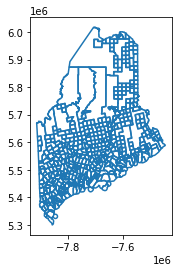

In [683]:
shapefiles_census.boundary.plot()

In [684]:
print(shapefiles_census.shape)
vest_me_18.shape

(593, 24)


(608, 14)

<AxesSubplot:>

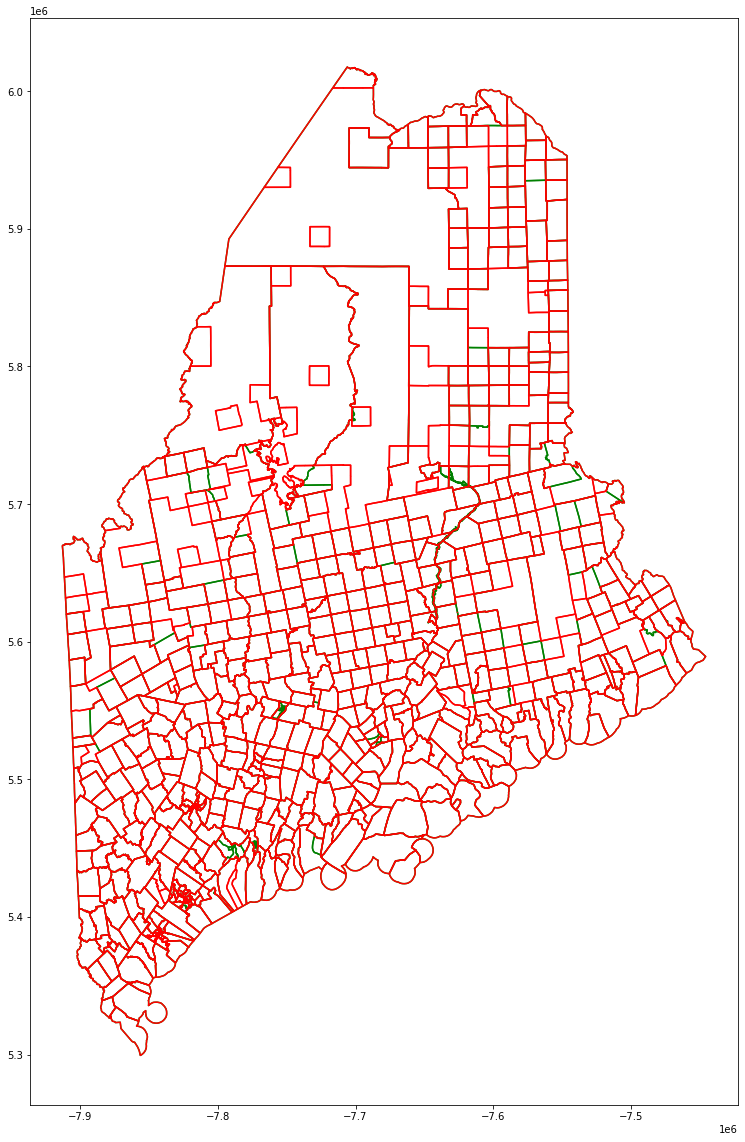

In [685]:
ax = shapefiles_census.boundary.plot(figsize=(20,20),color="green")
vest_me_18.boundary.plot(figsize=(20,20),ax=ax,color="red")

In [686]:
shapefiles_census[shapefiles_census['NAMELSAD'].str.contains('Biddeford')]


,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,...,MTFCC,geometry,COUSUBFP,COUSUBNS,CLASSFP,EFF_DATE,AUTHTYPE,DOCU,FORM_ID,AREA
169,23,031,004860,Biddeford,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7855292.149 5387519.570 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [687]:
biddeford_shapefile = gp.read_file('./raw-from-source/Town_Info/Biddeford/2018_Ward/2018_Ward.shp')

In [688]:
biddeford_shapefile = biddeford_shapefile.to_crs(3857)

In [689]:
biddeford_shapefile['STATEFP'] = '23'
biddeford_shapefile['COUNTYFP'] = '031'
biddeford_shapefile.rename(columns={'Ward':'NAMELSAD'}, inplace=True)

In [690]:
biddeford_shapefile["NAMELSAD"].replace({'3':"Biddeford 3", '1':"Biddeford 1", '4':"Biddeford 4", '2':'Biddeford 2', '5':'Biddeford 5', '6':'Biddeford 6','7':'Biddeford 7'}, inplace=True)
biddeford_shapefile

,NAMELSAD,SHAPE_area,SHAPE_len,geometry,STATEFP,COUNTYFP
0,Biddeford 3,2.171580e+08,116037.876390,"MULTIPOLYGON (((-7840272.885 5383326.622, -784...",23,031
1,Biddeford 1,9.963425e+08,176902.747740,"POLYGON ((-7838003.728 5384639.934, -7837981.3...",23,031
2,Biddeford 4,1.864198e+07,40026.186315,"POLYGON ((-7843005.510 5386489.919, -7842989.4...",23,031
3,Biddeford 2,5.538994e+07,51690.234763,"POLYGON ((-7838003.728 5384639.934, -7838183.2...",23,031
4,Biddeford 5,1.440942e+07,33906.905158,"MULTIPOLYGON (((-7842344.315 5387331.629, -784...",23,031
5,Biddeford 6,2.118690e+08,121655.114619,"POLYGON ((-7843893.391 5388173.226, -7843924.3...",23,031
6,Biddeford 7,1.333307e+08,104525.940489,"POLYGON ((-7844230.598 5387106.815, -7844178.5...",23,031


In [691]:
biddeford_shapefile = biddeford_shapefile.drop(['SHAPE_area', 'SHAPE_len'], axis=1)

In [692]:
shapefiles_census = shapefiles_census.append(biddeford_shapefile, ignore_index = True)

In [693]:
shapefiles_census

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,...,MTFCC,geometry,COUSUBFP,COUSUBNS,CLASSFP,EFF_DATE,AUTHTYPE,DOCU,FORM_ID,AREA
0,23,001,019105,Durham,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7817369.025 5462128.237 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23,001,020601,Auburn Ward 1,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7825981.165 5491825.668 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,001,020602,Auburn Ward 2,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7826218.825 5482213.694 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23,001,020603,Auburn Ward 3,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7827567.458 5480409.100 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23,001,020604,Auburn Ward 4,A,00,None,None,None,None,...,G5240,"POLYGON Z ((-7827393.683 5471255.509 0.000, -7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,23,031,NaN,Biddeford 4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"POLYGON ((-7843005.510 5386489.919, -7842989.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,23,031,NaN,Biddeford 2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"POLYGON ((-7838003.728 5384639.934, -7838183.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,23,031,NaN,Biddeford 5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"MULTIPOLYGON (((-7842344.315 5387331.629, -784...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,23,031,NaN,Biddeford 6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"POLYGON ((-7843893.391 5388173.226, -7843924.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [694]:
#Add a join column to the source shapefile
shapefiles_census["join_col"]=shapefiles_census['COUNTYFP']+shapefiles_census['NAMELSAD']
shapefiles_census['join_col'] = shapefiles_census['join_col'].str.upper()
df_with_absentee_reallocated['join_col'] = df_with_absentee_reallocated['join_col'].str.upper()

In [695]:
join_attempt_one = pd.merge(df_with_absentee_reallocated,shapefiles_census,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

right_only    427
left_only     409
both          173
Name: _merge, dtype: int64


In [696]:
join_attempt_one[join_attempt_one['_merge'] != 'both'][['County_FIPS','Precinct','COUNTYFP','NAME','join_col']].to_csv('./test2.csv')